<div align="center">
<font size="4"> Context  </font>  
</div> 

Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress. The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

<div align="center">
<font size="4"> Data  </font>  
</div> 

This dataset contains **2126 records** of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into **3 classes**:

- Normal
- Suspect
- Pathological

Link to dataset is [here](https://www.kaggle.com/andrewmvd/fetal-health-classification).

<h2 style=color:Teal align="left"> Table of Contents </h2>

### 1 Import packages
#### 1.1 Kaggle and other imports
#### 1.2 Visuzalization imports
#### 1.3 Import Scikit-Learn
#### 1.4 Import LightGBM
### 2 Configs
### 3 Dataset
#### 3.1 Class imbalance
#### 3.2 Data scaling
#### 3.3 Data split
#### 3.4 Class weights
#### 3.5 Validation set
### 4 Model
#### 4.1 Build model
#### 4.2 Fit model
#### 4.3 Feature importance
### 5 Grid search
#### 5.1 Grid parameters
#### 5.2 Fit model
#### 5.3 Save optimum parameters
#### 5.4 Fit tuned model
#### 5.5 Feature importance for tuned model


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1 Import packages </h1>

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1.1 Kaggle and other imports </h1>

In [1]:
import os
import gc
import time
import tqdm
import pickle
import random

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-health-classification/fetal_health.csv


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1.2 Visualization imports </h1>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

import warnings
warnings.filterwarnings('ignore')

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1.3 Import Scikit-Learn </h1>

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1.4 Import LightGBM </h1>

In [4]:
import lightgbm as lgb

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 2 Configs </h1>

In [5]:
SEED = 123      
random.seed(SEED)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3 Dataset </h1>

In [6]:
data = pd.read_csv("/kaggle/input/fetal-health-classification/fetal_health.csv")

In [7]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3.1 Class imbalance </h1>

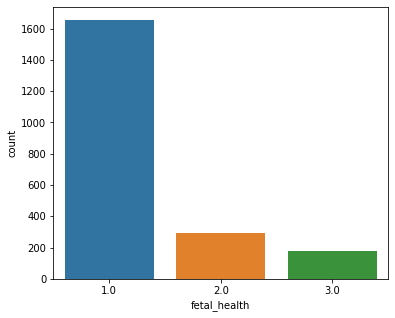

In [8]:
plt.figure(figsize=(6,5))
ax = sns.countplot(x = data['fetal_health'])

#1-Normal
#2-Suspect
#3-Pathological

In [9]:
label = LabelEncoder()
label.fit(data['fetal_health'])
data['fetal_health'] = label.transform(data['fetal_health'])

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3.2 Data scaling </h1>

In [10]:
X = data.drop(columns='fetal_health')
y = data['fetal_health']

In [11]:
X_scaled = MinMaxScaler().fit_transform(X.values)
X=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,0.259259,0.000000,0.0,0.000000,0.0,0.0,0.0,0.813333,0.044118,0.472527,...,0.344633,0.110092,0.034483,0.111111,0.0,0.472441,0.587156,0.403670,0.271375,1.0
1,0.481481,0.315789,0.0,0.400000,0.2,0.0,0.0,0.066667,0.279412,0.000000,...,0.717514,0.165138,0.655172,0.333333,0.1,0.637795,0.577982,0.577982,0.044610,0.5
2,0.500000,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.279412,0.000000,...,0.717514,0.165138,0.655172,0.277778,0.1,0.637795,0.568807,0.559633,0.048327,0.5
3,0.518519,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.323529,0.000000,...,0.644068,0.027523,0.413793,0.611111,0.0,0.606299,0.559633,0.550459,0.048327,1.0
4,0.481481,0.368421,0.0,0.533333,0.0,0.0,0.0,0.053333,0.323529,0.000000,...,0.644068,0.027523,0.413793,0.500000,0.0,0.606299,0.577982,0.559633,0.040892,1.0


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3.3 Data split </h1>

In [12]:
print('\nData split:\nTest size: {}\nVal  size: {}\n'.format(TEST_SIZE,VAL_SIZE))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, 
                                                    test_size = TEST_SIZE, 
                                                    random_state=SEED)

print('TRAIN: {} & {}'.format(X_train.shape, y_train.shape))
print('TEST:  {} & {}'.format(X_test.shape, y_test.shape))

val_len = int(X_train.shape[0]*VAL_SIZE)


Data split:
Test size: 0.2
Val  size: 0.15

TRAIN: (1700, 21) & (1700,)
TEST:  (426, 21) & (426,)


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3.4 Class weights </h1>

In [13]:
# Calculate class weights from sklearn
class_weight_array = class_weight.compute_class_weight('balanced', 
                                                       np.unique(y_train), 
                                                       y_train)
print('\nClass weights: {}'.format(class_weight_array)) 

# Class weights as dictionary for Keras
keys = [0,1,2] 
class_weight_dict = dict(zip(keys, class_weight_array.T))
print('\nClass weights dict: {}'.format(class_weight_dict))


Class weights: [0.42831948 2.40112994 4.01891253]

Class weights dict: {0: 0.42831947593852354, 1: 2.401129943502825, 2: 4.0189125295508275}


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3.5 Validation set </h1>

In [14]:
X_val = X_train[:val_len]
y_val = y_train[:val_len]

X_train_cut = X_train[val_len:]
y_train_cut = y_train[val_len:]

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 4 Model </h1>

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 4.1 Build model </h1>

In [15]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc_mu', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto'
           }

In [16]:
clf = lgb.LGBMClassifier(boosting_type = 'gbdt',
                         objective='multiclass',
                         metric='auc_mu', 
                         class_weight=class_weight_dict,
                         n_estimators=100,
                         num_leaves= 31,
                         colsample_bytree=1.0,
                         subsample=1.0,
                         learning_rate=0.1,
                         max_depth=-1, 
                         random_state=SEED, 
                         #silent=True, 
                         #n_jobs=4, 
)

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 4.2 Fit model </h1>

In [17]:
clf.fit(X_train_cut, y_train_cut, **fit_params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid's auc_mu: 0.982498


LGBMClassifier(class_weight={0: 0.42831947593852354, 1: 2.401129943502825,
                             2: 4.0189125295508275},
               metric='auc_mu', objective='multiclass', random_state=123)

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 4.3 Feature importance </h1>

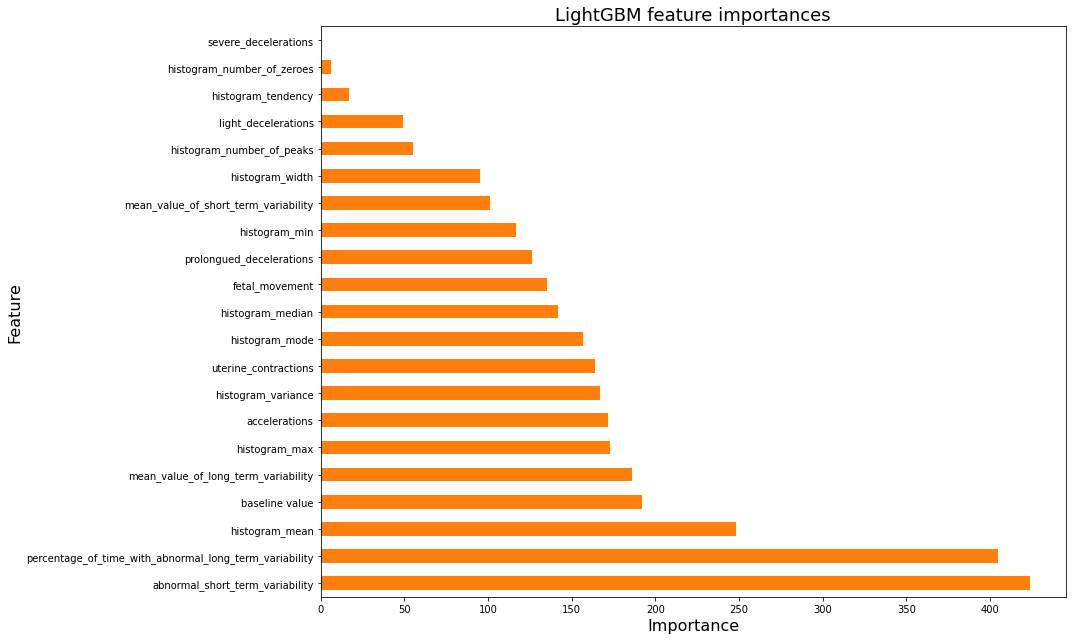

In [18]:
plt.figure(figsize=(15,9))

plt.title('LightGBM feature importances', fontsize=18)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)

feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(34).plot(kind='barh', color='tab:orange')

plt.tight_layout()

plt.savefig('lgbm_kfold_feature_importances_default.png')

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5 Grid search </h1>

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5.1 Grid parameters </h1>

In [19]:
# These parameters will be used in gridsearch and will be found optimum parameters
param_grid = {
    'class_weight': [class_weight_dict],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['multiclass'],
    'metric': ['auc_mu'],
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [50, 100, 200],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.7, 0.8],
    'max_depth': [5, 10, 50],
    'random_state': [SEED]
}
# 2160 fits (432x5), keep it not too big

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5.2 Fit model</h1>

In [20]:
lgbm = lgb.LGBMClassifier() 

#lgbm.fit(X_train_cut, y_train_cut)

In [21]:
%%time

# Grid search with 5-fold cross-validation
lgbm_cv = GridSearchCV(lgbm, 
                       param_grid, 
                       cv=5, 
                       n_jobs=None, 
                       verbose=0) # set to 2 for long output

lgbm_cv.fit(X_train_cut, y_train_cut)

CPU times: user 3h 23min 21s, sys: 6min 28s, total: 3h 29min 49s
Wall time: 53min 29s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'class_weight': [{0: 0.42831947593852354,
                                           1: 2.401129943502825,
                                           2: 4.0189125295508275}],
                         'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 50], 'metric': ['auc_mu'],
                         'n_estimators': [100, 500],
                         'num_leaves': [50, 100, 200],
                         'objective': ['multiclass'], 'random_state': [123],
                         'subsample': [0.7, 0.8]})

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5.3 Save optimum parameters </h1>

In [22]:
# Print optimum parameters
print('\nGrid search optimum parameters:\n{}'.format(lgbm_cv.best_params_))
# Save the model parameters
filename = 'model_lgbm_kfold_gridsearch_best_params.pickle'
pickle.dump(lgbm_cv.best_params_, open(filename, 'wb'))
# Load the model paarmeters
with open(filename, 'rb') as file:
    best_params = pickle.load(file)
print('\nGrid search optimum parameters [loaded]:\n{}'.format(best_params))


Grid search optimum parameters:
{'boosting_type': 'gbdt', 'class_weight': {0: 0.42831947593852354, 1: 2.401129943502825, 2: 4.0189125295508275}, 'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'metric': 'auc_mu', 'n_estimators': 500, 'num_leaves': 50, 'objective': 'multiclass', 'random_state': 123, 'subsample': 0.7}

Grid search optimum parameters [loaded]:
{'boosting_type': 'gbdt', 'class_weight': {0: 0.42831947593852354, 1: 2.401129943502825, 2: 4.0189125295508275}, 'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'metric': 'auc_mu', 'n_estimators': 500, 'num_leaves': 50, 'objective': 'multiclass', 'random_state': 123, 'subsample': 0.7}


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5.4 Fit tuned model</h1>

In [23]:
# Tuned model with optimum parameters
clf_tuned = lgb.LGBMClassifier(**best_params) # == lgbm_cv.best_params_

# Fit model
clf_tuned.fit(X_train_cut, y_train_cut, **fit_params)

# Predict
y_test_pred_tuned = clf_tuned.predict(X_test) 
# Find the accuracy of y_test and predicitons, and round the result
acc_tuned = round(accuracy_score(y_test, y_test_pred_tuned), 4) 
print('Accuracy: {}%'.format(acc_tuned*100))

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid's auc_mu: 0.980606
Accuracy: 91.08000000000001%


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5.5 Feature importance for tuned model</h1>

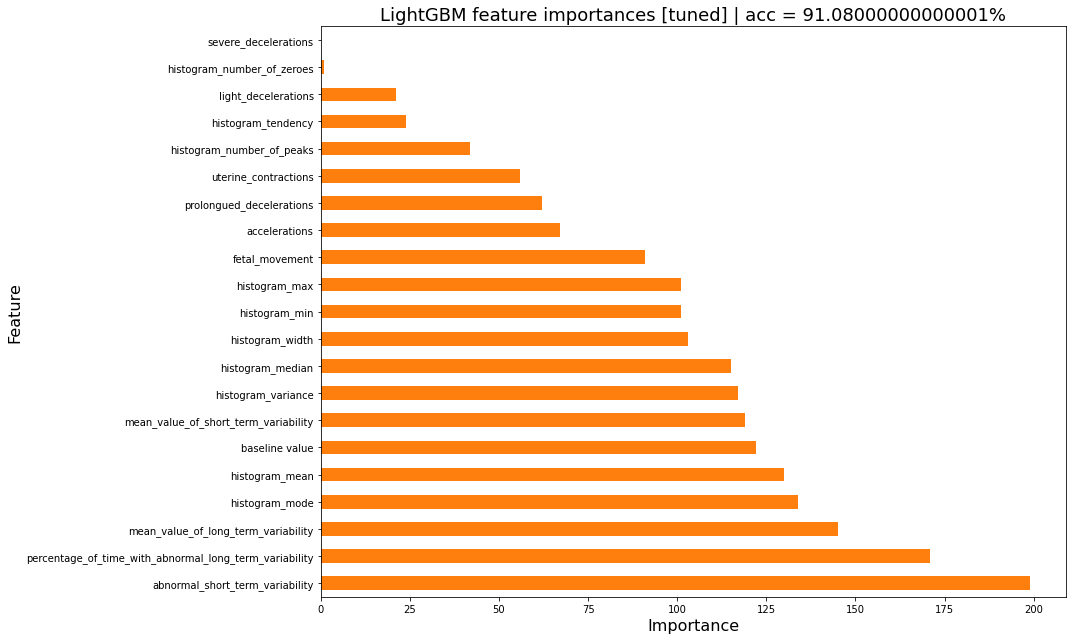

In [24]:
plt.figure(figsize=(15,9))
plt.title('LightGBM feature importances [tuned] | acc = {}%'.format(acc_tuned*100), fontsize=18)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
feat_imp = pd.Series(clf_tuned.feature_importances_, index=X.columns)
feat_imp.nlargest(50).plot(kind='barh', color='tab:orange')
plt.tight_layout()
plt.savefig('lgbm_5fold_feature_importances_tuned.png')

In [25]:
lgbm_cv.cv_results_

{'mean_fit_time': array([0.13403473, 0.13310246, 0.13181896, 0.13294826, 0.13350811,
        0.13285747, 0.67134199, 0.68929415, 0.66981359, 0.67600398,
        0.68385396, 0.67132573, 0.44406896, 0.28512187, 0.28650155,
        0.28713942, 0.31088753, 0.28715   , 1.46501989, 1.4715189 ,
        1.50076442, 1.61588321, 1.47189312, 1.48367639, 0.3723608 ,
        0.36864557, 0.37417431, 0.387287  , 0.37835927, 0.37651315,
        2.20105939, 2.00483408, 2.138342  , 2.29861851, 2.16827178,
        2.15634723, 0.12774897, 0.12845211, 0.19197154, 0.21307559,
        0.12770276, 0.1265955 , 0.64808717, 0.63263659, 0.63381414,
        0.64974685, 0.63282614, 0.63060966, 0.28732686, 0.28786373,
        0.30798154, 0.29400358, 0.29489045, 0.29526091, 1.22677588,
        1.09062185, 1.09557071, 1.10657082, 1.12339568, 1.24850597,
        0.39141064, 0.38999438, 0.43109488, 0.41147833, 0.41719232,
        0.42558599, 1.29774566, 1.28550153, 1.50862961, 1.38802328,
        1.38417501, 1.39882431,

In [26]:
best_feat_10 = list(feat_imp.nlargest(10).index)
best_feat_10

['abnormal_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability',
 'histogram_mode',
 'histogram_mean',
 'baseline value',
 'mean_value_of_short_term_variability',
 'histogram_variance',
 'histogram_median',
 'histogram_width']